In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import multiprocessing
from item.item_list import (
    ItemList,
    Item
)
from nlp.utils import (
    read_json_file,
    plot_histogram,
    get_completetext,
    plot_wordcloud,
    print_statistics,
    groups_frequency_sort)
from nlp.preprocessing import (
    clean_text,
    preprocess,
    tokenize,
    preprocess_document,
    tokenize_document,
    get_stopwords, 
    lemmatization_document,
    get_canonical_words,
    spellcheck_document)
from nlp.pos_tagging import (
    get_tokens_tags
)
from nlp.word_embeddings import (
    load_word_embeddings
)
from item.clustering.evaluate import (
    get_score_pickle,
    evaluate_results_pickle,
    evaluate_results
)
from item.clustering.utils import (
    load_clustering_results_pickle,
    load_clustering_results,
    load_models_pickle
)
from item.clustering.item_representation import (
    load_items_embeddings,
    get_group_embeddings_matrix,
    get_words_plus_categories_embeddings,
    get_items_embeddings,
    normalize
)

from hdbscan.prediction import approximate_predict

# Find clusters of the items in the test set

In [2]:
clustering_model, reducer_model = load_models_pickle('./precificacao/word2vec_cbow50/v3/SUB+MED+unit+num_concat_umap_sample20_hdbscan/')

In [3]:
results_train, outliers_train, prices_train = load_clustering_results_pickle('./precificacao/word2vec_cbow50/v3/SUB+MED+unit+num_concat_umap_sample20_hdbscan/')

In [4]:
# It gets the descriptions processed:
itemlist = ItemList()
itemlist.load_items_from_file('../dados/items_preprocessed_v3_test.zip')

In [5]:
# It gets the descriptions processed [TRAINING]:
itemlist_train = ItemList()
itemlist_train.load_items_from_file('../dados/items_preprocessed_v3_train.zip')

In [6]:
# Get the tags of tokens descriptions
word_class = get_tokens_tags(itemlist.unique_words)

In [7]:
# word embeddings file, each line contains a word embedding
# word_embeddings_file = '../../../embeddings/fasttext/skip_s300.txt'
word_embeddings_file = '../../../embeddings/word2vec/cbow_s50.txt'

In [8]:
# read word embeddings from file and store them in a map
word_embeddings = load_word_embeddings(word_embeddings_file, itemlist.unique_words)

In [9]:
def remove_new_tokens_from_embeddings(itemlist, itemlist_train, word_embeddings):
    test_tokens = set(itemlist.unique_words)
    train_tokens = set(itemlist_train.unique_words)
    new_tokens = test_tokens - train_tokens
    
    for token in new_tokens:
        word_embeddings.pop(token, None)

    return word_embeddings

In [10]:
def get_price(_item):
    item_dict = _item
    return item_dict['preço']

In [11]:
def predict_items_clusters(itemlist, word_embeddings, word_class, reducer_model,
                           clustering_model, categories=None, embedding_type=None,
                           embedding_size=50, operation='mean'):

    items_embeddings = get_items_embeddings(itemlist.items_df, word_embeddings, word_class,
                                            categories=categories, embedding_type=embedding_type,
                                            operation=operation)

    items_embeddings = normalize(items_embeddings)
    # It gets the reduced vector for the item
    items_embeddings = reducer_model.transform(X=items_embeddings)
    # It gets the item cluster
    clusters = approximate_predict(clustering_model, items_embeddings)
    
    results = []
    num_items = len(itemlist.items_df)
    
    # ([4, 5, 6, 7, 8], [0.94, ...])
    for item_id in range(num_items):
        cluster_id = str(clusters[0][item_id])
        cluster_prob = clusters[1][item_id]
        item_dict = itemlist.items_df.loc[item_id].to_dict()
        dsc_unidade_medida = item_dict['dsc_unidade_medida']
        price = item_dict['preco']
        licitacao = item_dict['licitacao']
        item_result = {'item_id': item_id, 'cluster': cluster_id,
                       'cluster_prob': cluster_prob, 'price': price,
                       'dsc_unidade_medida': dsc_unidade_medida,
                       'seq_dim_licitacao': licitacao}
        results.append(item_result)
    
    return results

In [12]:
results = predict_items_clusters(itemlist, word_embeddings, word_class, reducer_model, \
                                clustering_model, categories=['unidades_medida', 'numeros'], \
                                embedding_type=['N', 'MED'], operation='concatenate')

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs


In [13]:
results

[{'item_id': 0,
  'cluster': '-1',
  'cluster_prob': 0.0,
  'price': 13.9,
  'dsc_unidade_medida': 'un',
  'seq_dim_licitacao': 1075023},
 {'item_id': 1,
  'cluster': '6377',
  'cluster_prob': 1.0,
  'price': 62.0,
  'dsc_unidade_medida': 'jogo',
  'seq_dim_licitacao': 1067054},
 {'item_id': 2,
  'cluster': '1427',
  'cluster_prob': 0.7188066023683887,
  'price': 1.89,
  'dsc_unidade_medida': 'capsula',
  'seq_dim_licitacao': 1080244},
 {'item_id': 3,
  'cluster': '5034',
  'cluster_prob': 0.006156208836185732,
  'price': 1.59,
  'dsc_unidade_medida': 'un',
  'seq_dim_licitacao': 1136759},
 {'item_id': 4,
  'cluster': '3556',
  'cluster_prob': 0.9145787408012831,
  'price': 148.0,
  'dsc_unidade_medida': 'kit',
  'seq_dim_licitacao': 1126107},
 {'item_id': 5,
  'cluster': '278',
  'cluster_prob': 1.0,
  'price': 7.3,
  'dsc_unidade_medida': 'pacote',
  'seq_dim_licitacao': 1008434},
 {'item_id': 6,
  'cluster': '2085',
  'cluster_prob': 0.010383915096320378,
  'price': 24.0,
  'dsc_uni

In [55]:
len(results)

294661

In [56]:
len(itemlist.items_df) - len(results)

0

In [57]:
count = 0

for r in results:
    if r['cluster'] == '-1' or r['cluster'][:-2] == '-1':
        count += 1

count

64495

In [58]:
100*(count/len(itemlist.items_df))

21.887864359382476

In [59]:
clusters_probs = []

for result in results:
    clusters_probs.append(result['cluster_prob'])

In [60]:
len(clusters_probs)

294661

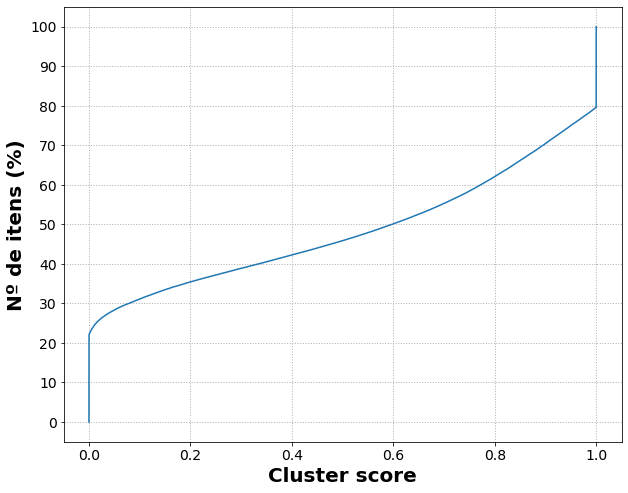

<Figure size 432x288 with 0 Axes>

In [61]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.pyplot import yticks

# fit a cdf
ecdf = ECDF(clusters_probs)

fig, (axis1) = plt.subplots(figsize=(10,8))
x_label = 'Cluster score'
y_label = 'Nº de itens (%)'

plt.plot(ecdf.x, ecdf.y)

axis1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
locs, labels = yticks()
yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
       [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

axis1.set_xlabel(x_label, fontsize=20, weight='bold')
axis1.set_ylabel(y_label, fontsize=20, weight='bold')

plt.grid(axis='both', linestyle=':', linewidth=1.0)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()
plt.clf()

In [62]:
print('mean: %s' % np.mean(clusters_probs))
print('median: %s' % np.median(clusters_probs))
print('std: %s' % np.std(clusters_probs))

mean: 0.5167259980575049
median: 0.5972102498984587
std: 0.41080710639196955


# PRICING: get the statistics for each cluster finded in the train set

In [63]:
def get_items_sample(itemslist, prices, items):

    new_items = []
    if len(prices) == 0:
        return new_items
    
    mini = np.min(prices)
    maxi = np.max(prices)
    for item in items:
        item_dict = itemslist.items_df.loc[item].to_dict()
        if item_dict['preco'] >= mini and item_dict['preco'] <= maxi:
            new_items.append(item)
            
    return new_items

In [64]:
def get_items_prices(itemlist, items):

    prices = []
    for item in items:
        prices.append(itemlist.items_dc.loc[item].to_dict()['preco'])
    
    return prices

In [65]:
def get_clusters_prices(itemlist, results):

    cluster_prices = {}

    for cluster, items in results.items():
        prices = get_items_prices(itemlist, items)
        cluster_prices[cluster] = prices
        
    return cluster_prices

In [66]:
def remove_outlier_prices(itemslist, cluster_items, cluster_prices, threshold, baseline=True):

    for cluster, prices in cluster_prices.items():
        if baseline and '_' not in cluster:
            continue
        elif not baseline and cluster == '-1':
            continue
        std = np.std(prices)
        mean = np.mean(prices)
        if std/mean > threshold:
            prices.sort()
            lower = np.percentile(prices, 10)
            upper = np.percentile(prices, 90)
            new_prices = [p for p in prices if p > lower and p < upper]
            cluster_prices[cluster] = new_prices
            cluster_items[cluster] = get_items_sample(itemslist, new_prices, cluster_items[cluster])
    
    return cluster_prices, cluster_items

In [67]:
def get_percentiles(prices):
    
    percentiles = []
    for i in range(10, 100, 10):
        percentiles.append(np.percentile(prices, i))

    return percentiles

In [68]:
def sample_per_decile(itemslist, cluster_items, cluster_prices, threshold, baseline=True):
    
    for cluster, prices in cluster_prices.items():
        if baseline and '_' not in cluster:
            continue
        elif not baseline and cluster == '-1':
            continue
        std = np.std(prices)
        mean = np.mean(prices)
        if std/mean > threshold:
            prices.sort()
            items = []
            percentiles = get_percentiles(prices)
            first_percentile = [p for p in prices if p <= percentiles[0]]
            items_sample = get_items_sample(itemslist, first_percentile, cluster_items[cluster])
            items += list(random.sample(items_sample, int(0.2*len(items_sample))))
            for i in range(1, len(percentiles)):
                lower = percentiles[i - 1]
                upper = percentiles[i]
                percentile = [p for p in prices if p > lower and p > upper]
                items_sample = get_items_sample(itemslist, percentile, cluster_items[cluster])
                items += list(random.sample(items_sample, int(0.2*len(items_sample))))
            last_percentile = [p for p in prices if p >= percentiles[-1]]
            items_sample = get_items_sample(itemslist, last_percentile, cluster_items[cluster])
            items += list(random.sample(items_sample, int(0.2*len(items_sample))))
            cluster_items[cluster] = items
            cluster_prices[cluster] = get_items_prices(itemlist, items)

    return cluster_prices, cluster_items

In [69]:
def get_items_dataframe(itemslist, cluster_items, baseline=True):
    
    lines = []
    for cluster, items in cluster_items.items():
        for item in items:
            item_dict = itemslist.items_df.loc[item].to_dict()
            price = item_dict['preco']
            dsc_unidade_medida = item_dict['dsc_unidade_medida']
            dsc_unidade_medida = dsc_unidade_medida.lower()
            description = ' '.join(item_dict['original_prep'])
            licitacao = item_dict['licitacao']
            if baseline and ('_' not in cluster or cluster[-2:] == '-1'):
                line = (item, licitacao, 1, cluster, dsc_unidade_medida, description, price)
            elif not baseline and cluster == '-1':
                line = (item, licitacao, 1, cluster, dsc_unidade_medida, description, price)
            else:
                line = (item, licitacao, 0, cluster, dsc_unidade_medida, description, price)
            lines.append(line)

    columns = ('item_id', 'seq_dim_licitacao', 'outlier', 'cluster', 'dsc_unidade_medida', 'description', 'price')
    items_clusters_df = pd.DataFrame(lines, columns=columns)
    
    return items_clusters_df

In [70]:
def get_prices_statistics_df(items_clusters_df, dsc_unidade):

    results_df = items_clusters_df.drop('description', axis=1)
    results_df = results_df.drop('seq_dim_licitacao', axis=1)
    results_df = results_df[results_df['outlier'] == 0]
    results_df = results_df.drop('outlier', axis=1)
    if dsc_unidade:
        group_by = ['cluster', 'dsc_unidade_medida']
    else:
        group_by = ['cluster']

    results_grouped=results_df.groupby(group_by, as_index=False)['price'].mean()
    results_grouped=results_grouped.rename(columns = {'price':'mean'})
    results_grouped['count']=results_df.groupby(group_by, as_index=False)['price'].count().transform('price')
    results_grouped['max']=results_df.groupby(group_by, as_index=False)['price'].max().transform('price')
    results_grouped['min']=results_df.groupby(group_by, as_index=False)['price'].min().transform('price')
    results_grouped['median']=results_df.groupby(group_by, as_index=False)['price'].median().transform('price')
    results_grouped['std']=results_df.groupby(group_by)['price'].std().reset_index().transform('price')
    results_grouped['var']=results_df.groupby(group_by)['price'].var().reset_index().transform('price')
    results_grouped['quantile_1']=results_df.groupby(group_by)['price'].quantile(q=0.25).reset_index().transform('price')
    results_grouped['quantile_3']=results_df.groupby(group_by)['price'].quantile(q=0.75).reset_index().transform('price')

    return results_grouped

In [71]:
def get_prices_statistics_dict(cluster_prices, baseline=True):
    
    cluster_prices_statistics = {}
    
    for cluster, prices in cluster_prices.items():
        if baseline and '_' not in cluster:
            prices_statistics = {
                'mean': -1,
                'median': -1,
                'var': -1,
                'std': -1,
            }
        elif not baseline and cluster == '-1':
            prices_statistics = {
                'mean': -1,
                'median': -1,
                'var': -1,
                'std': -1,
            }
        else:
            prices_statistics = {
                'mean': np.mean(prices),
                'median': np.median(prices),
                'var': np.var(prices),
                'std': np.std(prices)
            }
        cluster_prices_statistics[cluster] = prices_statistics

    return cluster_prices_statistics

In [72]:
def pricing(itemslist, cluster_items, cluster_prices, dsc_unidade=True, remove_outliers=True, sample=False, threshold=0.3, baseline=True):
    if remove_outliers:
        cluster_prices, cluster_items = remove_outlier_prices(itemslist, cluster_items, cluster_prices, threshold, baseline)
    if sample:
        cluster_prices, cluster_items = sample_per_decile(itemslist, clisters_items, cluster_prices, threshold, baseline)

    items_clusters_df = get_items_dataframe(itemslist, cluster_items, baseline)
    cluster_prices_statistics = get_prices_statistics_df(items_clusters_df, dsc_unidade)

    return cluster_prices_statistics, items_clusters_df

In [73]:
cluster_prices = get_clusters_prices(itemlist_train, results_train)

In [74]:
cluster_prices_statistics, items_clusters_df = pricing(itemlist_train, results_train, cluster_prices, remove_outliers=True, threshold=0.5, dsc_unidade=True, baseline=False)

In [75]:
items_clusters_df.to_csv("./precificacao/word2vec_cbow50/v3/SUB+MED+unit+num_concat_umap_sample20_hdbscan/items_clusters_train.csv", sep=';', index=False)

In [76]:
cluster_prices_statistics.to_csv("./precificacao/word2vec_cbow50/v3/SUB+MED+unit+num_concat_umap_sample20_hdbscan/cluster_prices_statistics.csv", sep=';', index=False)

In [77]:
items_clusters_df.head(20)

,item_id,seq_dim_licitacao,outlier,cluster,dsc_unidade_medida,description,price
0,0,1191385,0,438,unidade,colagenase 0 6 ui g,8.97
1,2320,1165735,0,438,tubo,colagenase clorana 0 6 1 g,8.85
2,4821,1190944,0,438,unidade,colagenase 0 6 ui g,9.00
3,18087,1123485,0,438,un,colagenase puro,10.60
4,20346,1084253,0,438,tubo,colagenase,11.69
5,22556,1075826,0,438,tb,colagenase 18 ui 30 g,8.00
6,25435,1018688,0,438,bn,colagenase pom,9.43
7,26085,1133465,0,438,tubo,colagenase 1 2 u g,10.00
8,30742,1122677,0,438,unidade,colagenase com cloramfenicol,10.50
9,65608,1018651,0,438,bn,colagenase pom,12.95


In [78]:
cluster_prices_statistics.head(20)

,cluster,dsc_unidade_medida,mean,count,max,min,median,std,var,quantile_1,quantile_3
0,0,kg,10.020000,10,12.90,6.99,9.220,2.080080,4.326733,8.7200,11.9000
1,0,kilo,8.818947,19,12.44,4.20,9.450,2.239491,5.015321,6.7500,9.9750
2,0,kilogramas,4.380000,1,4.38,4.38,4.380,NaN,NaN,4.3800,4.3800
3,0,kl,7.900000,1,7.90,7.90,7.900,NaN,NaN,7.9000,7.9000
4,0,pacote,6.012857,63,9.90,3.94,5.970,1.575017,2.480679,4.5250,7.0750
5,0,pacote 1 quilograma,5.500000,1,5.50,5.50,5.500,NaN,NaN,5.5000,5.5000
6,0,pacote 1 unidade,10.000000,1,10.00,10.00,10.000,NaN,NaN,10.0000,10.0000
7,0,pacote 500 gramas,6.444667,15,8.50,4.80,5.980,1.215771,1.478098,5.5000,7.3750
8,0,pacotes,7.965000,2,9.98,5.95,7.965,2.849640,8.120450,6.9575,8.9725
9,0,pc,7.237500,4,8.75,4.65,7.775,1.908042,3.640625,6.3750,8.6375


# Get reference prices for the items in the test set

In [79]:
def get_reference_prices(results, cluster_price_statistics, dsc_unidade=True):

    if dsc_unidade:
        indexes = ['cluster', 'dsc_unidade_medida']
    else:
        indexes = ['cluster']
    prices_dict = cluster_prices_statistics.set_index(indexes).to_dict('index')
    item_reference_price = {}

    for result in results:
        if dsc_unidade:
            group = (result['cluster'], result['dsc_unidade_medida'])
        else:
            group = result['cluster']
        if group not in prices_dict:
            statistics = {
                'mean': -1,
                'median': -1,
                'var': -1,
                'std': -1,
                'count': -1,
                'max': -1,
                'min': -1,
                'quantile_1': -1,
                'quantile_3': -1
            }
        else:
            statistics = prices_dict[group]
        result.update(statistics)
        item_reference_price[result['item_id']] = result

    items_test_df = pd.DataFrame.from_dict(item_reference_price, 'index')
    return items_test_df

In [80]:
items_test_df = get_reference_prices(results, cluster_prices_statistics, dsc_unidade=True)

In [81]:
items_test_df.head(10)

,item_id,cluster,cluster_prob,price,dsc_unidade_medida,seq_dim_licitacao,mean,median,var,std,count,max,min,quantile_1,quantile_3
0,0,-1,0.000000,13.90,un,1075023,-1.000000,-1.0000,-1.000000,-1.000000,-1,-1.00,-1.000,-1.0000,-1.0000
1,1,6377,1.000000,62.00,jogo,1067054,50.350000,50.3500,102.245000,10.111627,2,57.50,43.200,46.7750,53.9250
2,2,1427,0.718807,1.89,capsula,1080244,1.930482,0.6715,23.409820,4.838370,202,54.00,0.100,0.3085,1.5175
3,3,5034,0.006156,1.59,un,1136759,3.572222,2.7500,3.824644,1.955670,9,7.90,1.990,2.5000,3.3000
4,4,3556,0.914579,148.00,kit,1126107,74.806000,51.0400,2383.654133,48.822681,25,204.90,18.550,36.0000,103.9700
5,5,278,1.000000,7.30,pacote,1008434,9.588462,9.9000,13.618531,3.690329,13,13.90,2.880,6.9800,12.4000
6,6,2085,0.010384,24.00,l,1160668,31.266667,22.6700,652.496233,25.544006,3,60.00,11.130,16.9000,41.3350
7,7,512,0.877126,0.04,capsula,1009984,0.056625,0.0505,0.000223,0.014918,8,0.09,0.046,0.0470,0.0590
8,8,-1,0.000000,445.00,unidade,1072003,-1.000000,-1.0000,-1.000000,-1.000000,-1,-1.00,-1.000,-1.0000,-1.0000
9,9,5145,1.000000,595.00,unidade,1008597,9.752500,8.7500,67.297279,8.203492,8,21.50,0.430,3.9225,14.2250


In [82]:
items_test_df.to_csv("./precificacao/word2vec_cbow50/v3/SUB+MED+unit+num_concat_umap_sample20_hdbscan/items_clusters_test.csv", sep=';', index=False)

# Get reference price for an arbitray item

In [ ]:
item = "Dipirona Sódica 500mg 10 Comprimidos"

In [ ]:
canonical_form, word_class = get_canonical_words()

In [ ]:
def get_item_vec(_item, word_embeddings, word_class, categories=None, embedding_type=None,
                 embedding_size=50, norm=True, operation='mean'):
    
    if operation == 'mean':
        item_vec = get_item_embedding(_item.get_item_dict(), word_embeddings, word_class, \
                    categories=categories, embedding_type=embedding_type, embedding_size=embedding_size)
    elif operation == 'weighted':
        item_vec = get_item_embedding_weighted(_item.get_item_dict(), word_embeddings, word_class, \
                    categories=categories, embedding_type=embedding_type, embedding_size=embedding_size)
    elif operation == 'concatenate':
        item_vec = get_words_plus_categories_embeddings(_item.get_item_dict(), word_embeddings, word_class, \
                    categories=categories, embedding_type=embedding_type, embedding_size=embedding_size)
        
    if norm:
        item_vec = normalize(item_vec.reshape(1, -1))

    return item_vec

In [ ]:
def pricing_item(description, word_embeddings, word_class, canonical_form, reducer_model,
                 clustering_model, cluster_prices_statistics, categories=[], embedding_type=['N', 'MED'],
                 operation='mean'):

    cluster_price_statistics = cluster_prices_statistics.set_index('cluster').to_dict('index')
    right_word = read_json_file('../dados/palavras/right_words_nilc.json')
    stopwords_ = get_stopwords()
    relevant_stopwords = {'para', 'com', 'nao', 'mais', 'muito', 'so', 'sem', 'mesmo', 'mesma', 'ha', \
                          'haja', 'hajam', 'houver', 'houvera', 'seja', 'sejam', 'fosse', 'fossem', 'forem', \
                          'sera', 'serao', 'seria', 'seriam', 'tem', 'tinha', 'teve', 'tinham', 'tenha', \
                          'tiver', 'tiverem', 'tera', 'terao', 'teria', 'teriam', 'uma', 'mais', 'entre'}
    stopwords_ = stopwords_ - relevant_stopwords

    doc = preprocess_document(description, remove_numbers=False, stopwords=stopwords_)
    doc = tokenize_document(doc)
    doc = spellcheck_document(doc, right_word)
    doc = lemmatization_document(doc, canonical_form)
    
    item = Item()
    itemslist = ItemList()
    item.extract_entities(doc, None, None, None, description, itemslist.set_unit_metrics,
                          itemslist.set_colors, itemslist.set_materials, itemslist.set_sizes,
                          itemslist.set_quantities, itemslist.set_qualifiers, itemslist.set_numbers)
    
    embedding_size = len(list(word_embeddings.values())[0])
    item_emb = get_item_vec(item, word_embeddings, word_class, categories=categories,
                            embedding_type=embedding_type, embedding_size=embedding_size,
                            operation=operation)

    item_dict = item.get_item_dict()
    group = item_dict['palavras'][0]
    
    # It gets the reduced vector for the item
    item_emb_red = reducer_model[group].transform(item_emb)
    # It gets the item cluster
    cluster = approximate_predict(clustering_model[group], item_emb_red)
    cluster = group + '_' + str(cluster[0][0])

    if cluster not in cluster_prices_statistics:
        statistics = {
            'mean': -1,
            'median': -1,
            'var': -1,
            'std': -1
        }
    else:
        statistics = cluster_prices_statistics[cluster]
    
    statistics.update({'cluster': cluster})

    return statistics

In [ ]:
def get_clusters_items_desc(items_list, results, cluster, structured=False):
    
    clusters_items_desc = []
    if cluster not in results:
        return clusters_items_desc

    items = results[cluster]
    
    for item in items:
        item_dict = items_list[item].get_item_dict()
        if structured:
            clusters_items_desc.append(item_dict)
        else:
            clusters_items_desc.append(item_dict['original_prep'])
        
    return clusters_items_desc

In [ ]:
pricing_item(item, word_embeddings, word_class, canonical_form, reducer_model,
             clustering_model, cluster_prices_statistics, categories=['unidades_medida', 'numeros'],
             embedding_type=['N', 'MED'], operation='concatenate')

In [ ]:
clusters_items_desc = get_clusters_items_desc(itemlist_train.items_list, results_train, 'dipirona_20', structured=True)

In [ ]:
len(clusters_items_desc)

In [ ]:
clusters_items_desc